# Creating a deep learning dataset from google images
Inspired by Adrian Rosebrock, fast.ai course lesson 2

STEPS:
1. For every class label, google search the images. Scroll down until you have enough images for that class.

2. Save the urls of all the images into a file.

    1. Use cmd opt J on a mac (ctrl shift J for windows) to get the javascript console
    2. Copy the following code in the js console. It downloads a file containing the urls of all the images in the google search

    
    urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl')); window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));  

3. Repeat these steps for all the classes you want in the dataset


In [2]:
from fastai.vision import *

In [1]:
import warnings; 
warnings.simplefilter('ignore')

Downloading the images from the url csv files



In [7]:
file_name='horse.csv'
folder='horse'

In [13]:
file_name='camel.csv'
folder='camel'

In [16]:
file_name='zebra.csv'
folder='zebra'

In [19]:
file_name='elephant.csv'
folder='elephant'

In [20]:
path = Path('data/animals')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
path.ls()

[PosixPath('data/animals/zebra'),
 PosixPath('data/animals/horse'),
 PosixPath('data/animals/camel.csv'),
 PosixPath('data/animals/zebra.csv'),
 PosixPath('data/animals/elephant'),
 PosixPath('data/animals/horse.csv'),
 PosixPath('data/animals/camel'),
 PosixPath('data/animals/elephant.csv')]

In [9]:
classes = ['horse','camel','zebra','elephant']

In [21]:
download_images(path/file_name, dest, max_pics=500)


Remove images which can not be opened

In [22]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)


horse


camel


zebra


elephant


Get the data and its corresponding class labels from the folder names

In [23]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [24]:
data.classes

['camel', 'elephant', 'horse', 'zebra']

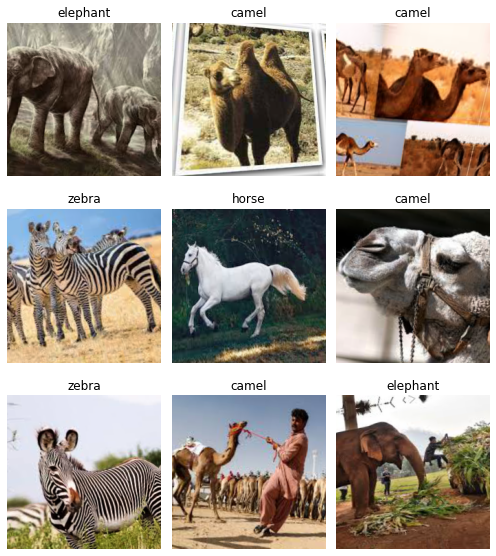

In [41]:
data.show_batch(rows=3, figsize=(7,8))

In [26]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [27]:
learn.fit_one_cycle(4)


epoch,train_loss,valid_loss,error_rate,time
0,0.977702,0.213271,0.055980,00:18
1,0.542244,0.186661,0.050891,00:18
2,0.372252,0.197677,0.045802,00:18
3,0.265801,0.182514,0.040712,00:18


In [28]:
learn.save('stage-1')


In [29]:
# Makes the pretrained  resnet layers trainable
learn.unfreeze()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


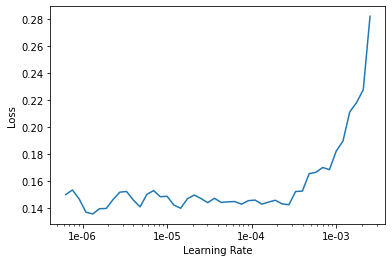

In [30]:
# Finds the learning rate, recorder.plot shows plot of lr vs loss
learn.lr_find()
learn.recorder.plot()

In [33]:
# Use the fit_one_cycle with the appropriate start and end lr from the recorder plot
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))


epoch,train_loss,valid_loss,error_rate,time
0,0.151873,0.176828,0.053435,00:24
1,0.129231,0.168286,0.043257,00:25


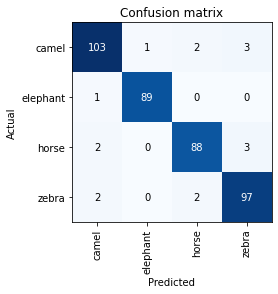

In [31]:
learn.save('stage-2')
learn.load('stage-2');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [32]:
from fastai.widgets import *

In [33]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )


In [34]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');


In [35]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)


In [42]:
ImageCleaner(ds, idxs, path)


Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [36]:
learn.export()


In [37]:
defaults.device = torch.device('cpu')


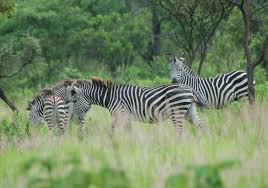

In [38]:
img = open_image('/content/data/animals/zebra/00000004.jpg')
img


In [39]:
learn = load_learner(path)
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj


'zebra'